# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

23:59:59 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=627345;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=912164;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=740790;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=237717;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:00:54 INFO      Auto-determined polynomial order: 0                                ]8;id=280165;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=347894;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:01:10 INFO      None 0-order polynomial fit with the mle method                               ]8;id=217080;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=435052;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=295820;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=593030;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=869844;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=323982;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=598014;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=27181;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:01:11 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=157462;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=17547;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=408753;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=504286;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=180141;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=411030;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=199667;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=625616;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=433653;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=773128;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

00:01:14 INFO      Now using 120 bins                                                          ]8;id=931128;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=40833;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:01:16 INFO      Auto-determined polynomial order: 1                                ]8;id=56378;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=763559;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:01:33 INFO      None 1-order polynomial fit with the mle method                               ]8;id=171683;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=10272;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=465344;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=559537;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=705723;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=952328;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=677253;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=634299;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=566133;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=353159;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=236141;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=799649;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=842210;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=77252;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=784636;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=534056;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=312255;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=911076;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=13324;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=357520;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:01:36 INFO      Auto-determined polynomial order: 1                                ]8;id=170172;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=551786;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:01:53 INFO      None 1-order polynomial fit with the mle method                               ]8;id=644808;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=240709;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=767078;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=779203;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=443933;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=20394;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=980937;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=436184;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=78861;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=489226;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

00:01:54 INFO      Auto-probed noise models:                                                    ]8;id=701643;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=230323;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=214788;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=992709;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=859987;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=470375;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=378232;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=165725;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=534064;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=525961;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

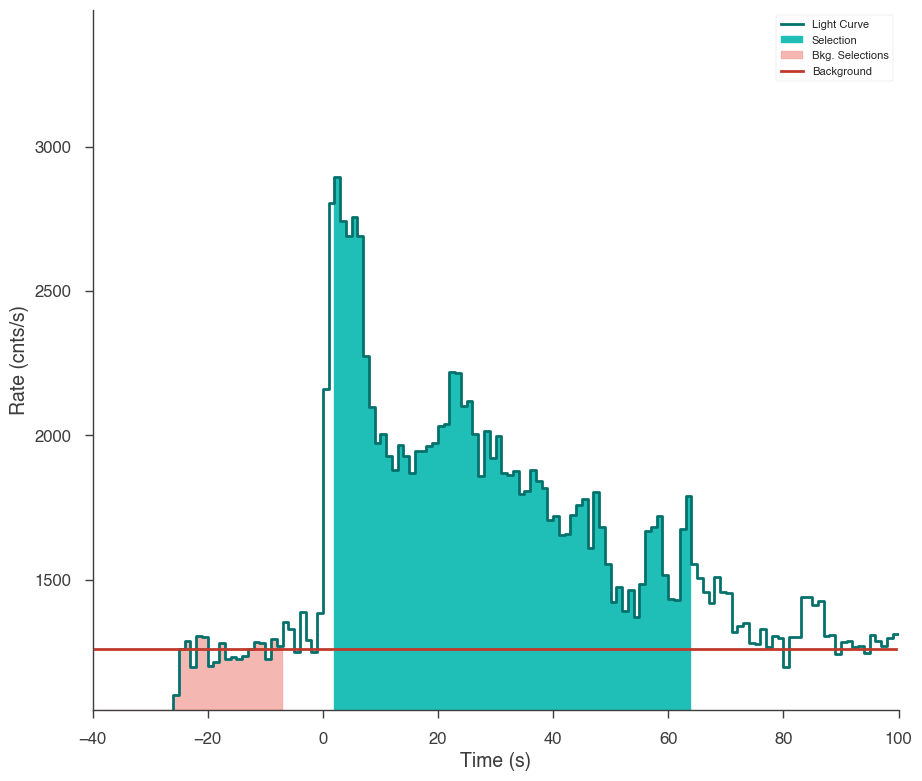

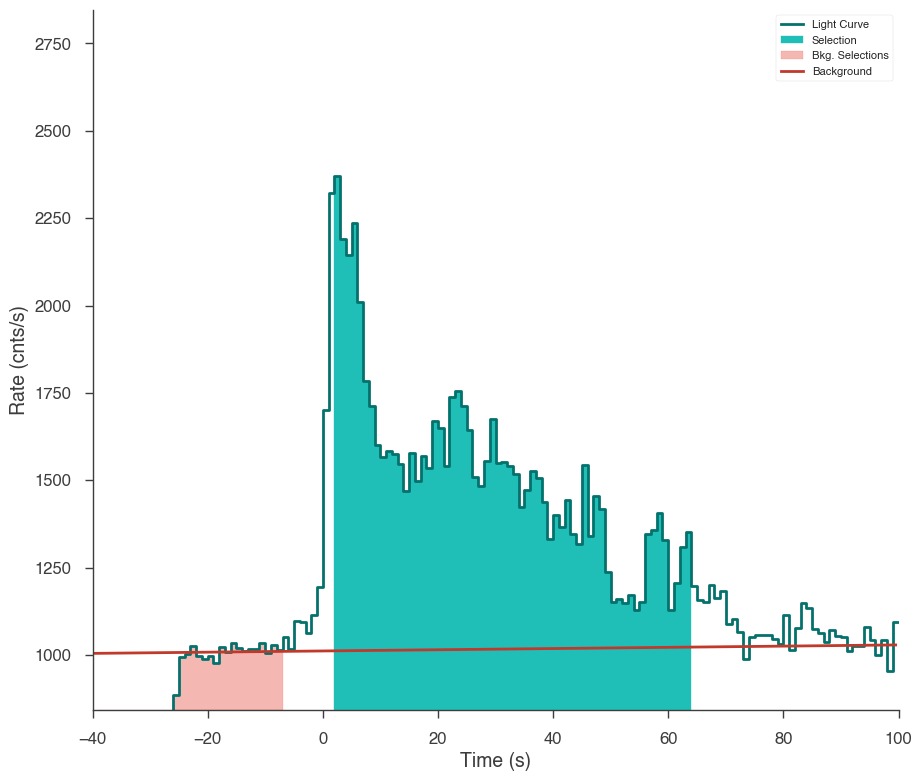

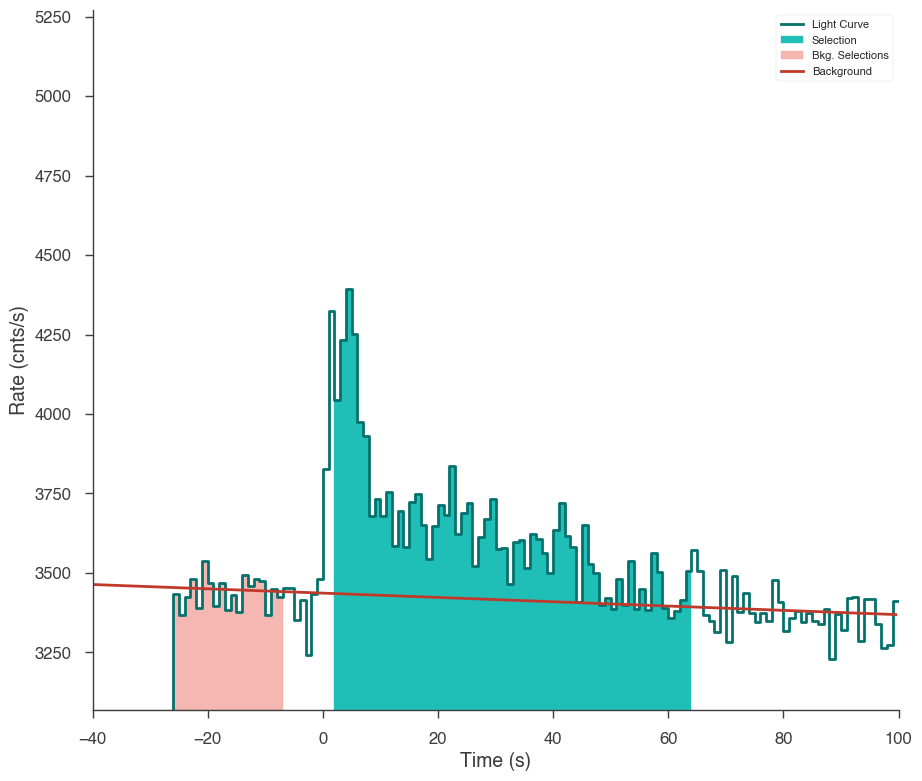

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

         INFO      sampler set to multinest                                                ]8;id=809791;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=756632;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

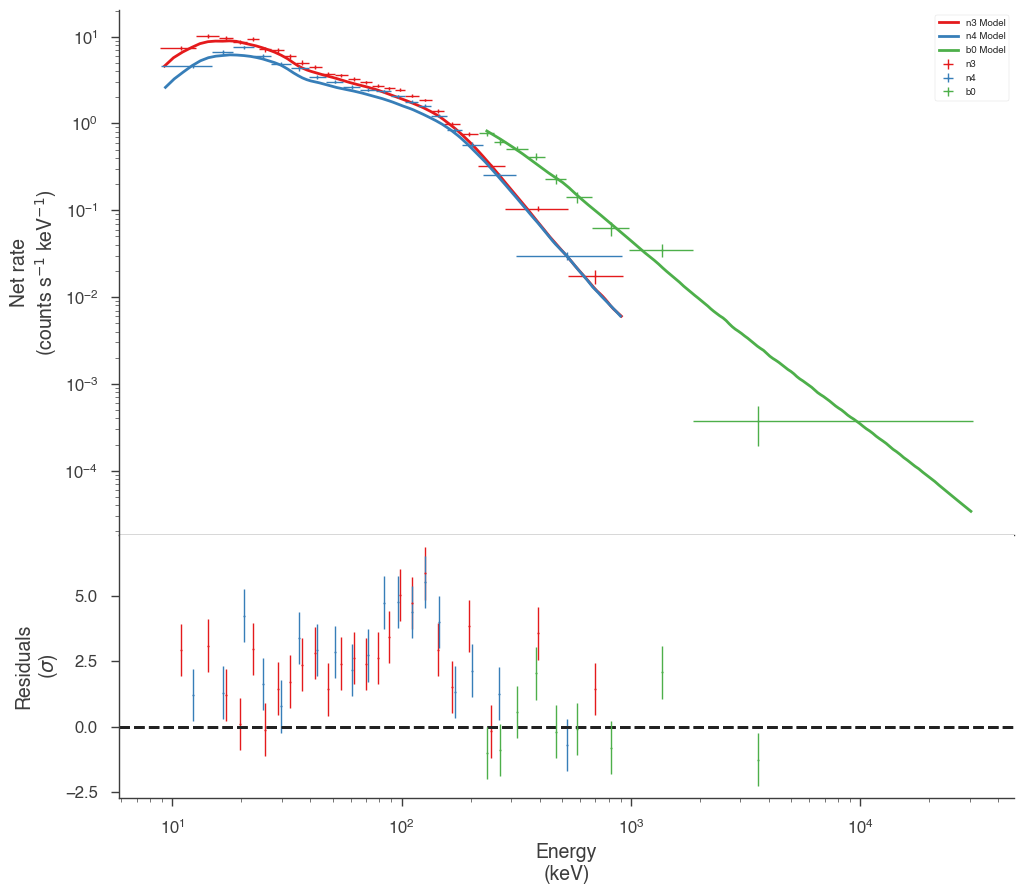

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3101.2077056373646      +/-  0.22443643514554612     
 Total Likelihood Evaluations:        21910
 Sampling finished. Exiting MultiNest



00:02:16 INFO      fit restored to maximum of posterior                                         ]8;id=757201;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=358217;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=427187;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=12345;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.476 -0.026 +0.012) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                  -1.089 -0.006 +0.034                 
GRB080916009...break_energy       (1.81 +0.22 +0.8) x 10^2              keV
GRB080916009...break_scale         (0.0 +1.7 +3.4) x 10^-1                 
GRB080916009...beta                      -1.96 -0.24 -0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1049.791332
n3        -1020.754200
n4        -1010.311323
total     -3080.856854

Values of statistical measures:

statistical measures
AIC              6171.884163
BIC              6191.116373
DIC              6179.924208
PDIC                4.370876
log(Z)          -1346.837394

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=514994;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=614572;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

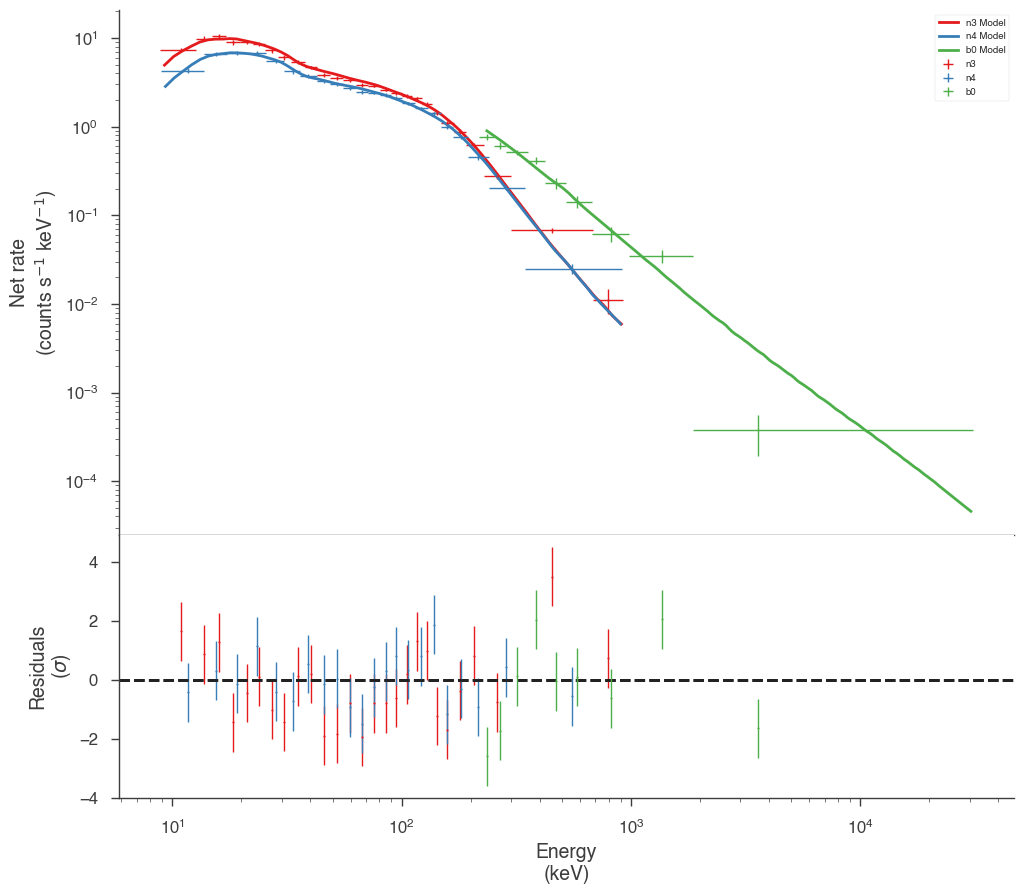

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

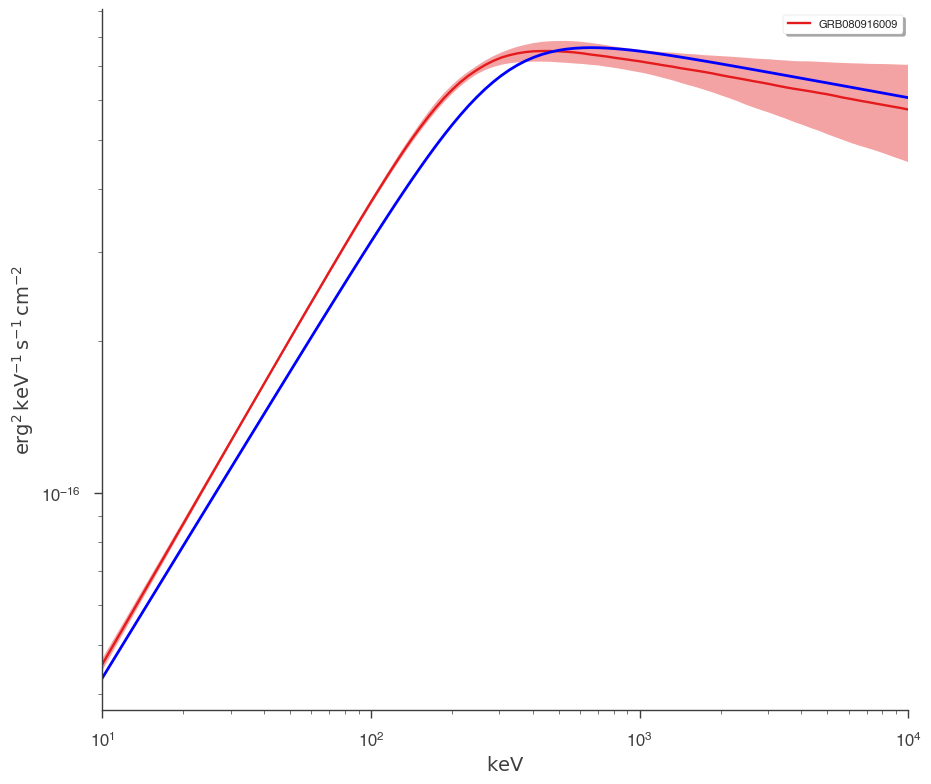

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

00:04:08 INFO      Created 15 bins via bayesblocks                                       ]8;id=455428;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=155979;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


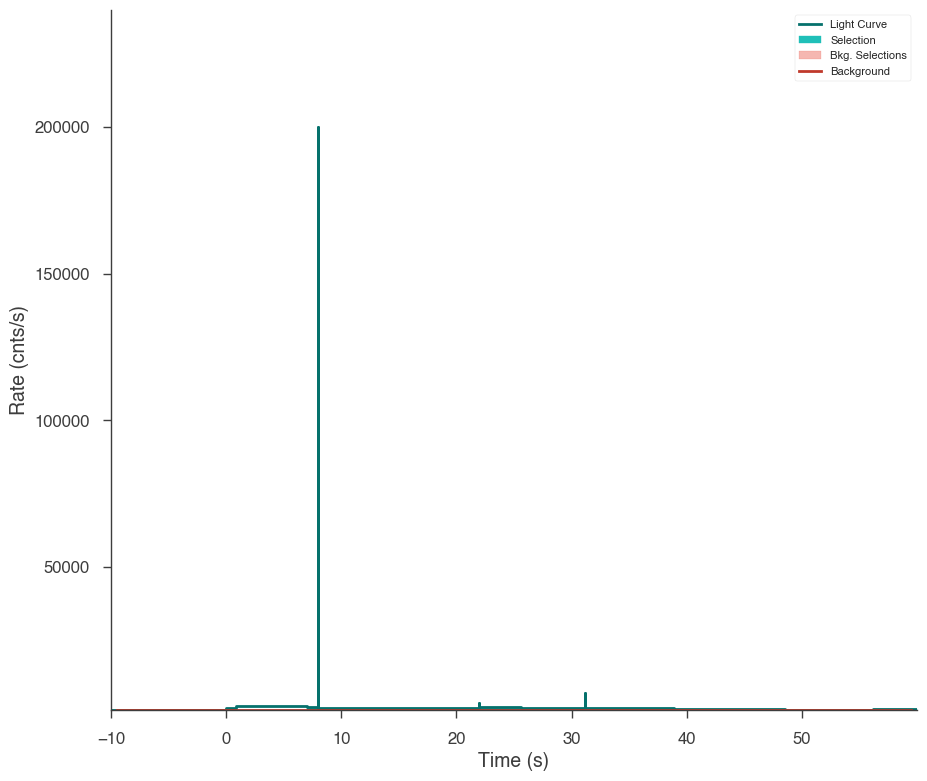

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

00:04:09 INFO      Created 12 bins via custom                                            ]8;id=62387;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=430473;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

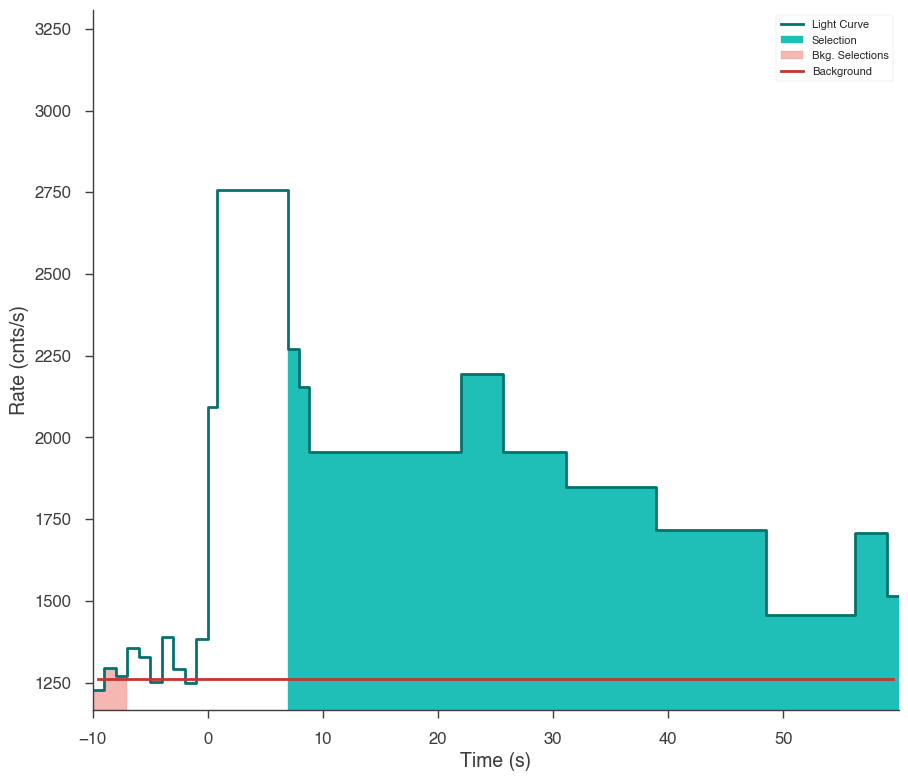

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=256111;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=367840;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

00:04:10 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=149917;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=533768;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=418100;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=20999;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=778453;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=380259;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=717994;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=518539;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

00:04:11 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=475911;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=574941;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=991635;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=242172;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=350580;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=963764;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=979785;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=940296;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=348187;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=880547;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=785679;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=180397;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 107 bins                                                          ]8;id=998234;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=473870;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=699207;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=346231;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -788.66325967889577      +/-  0.17806957661212480     
 Total Likelihood Evaluations:        16473
  analysing data from chains/fit-.txt
 Sampling finished. Exiting MultiNest


00:04:28 INFO      fit restored to maximum of posterior                                         ]8;id=788473;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=408857;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=866890;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=377929;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K         (3.6 +/- 0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.5 -1.5 +1.0) x 10^-1                 
grb.spectrum.main.Band.xp       (3.1 -0.5 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta           -2.02 -0.4 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.659426
n3_interval0      -250.192759
n4_interval0      -267.955301
total             -803.807487

Values of statistical measures:

statistical measures
AIC              1615.728288
BIC              1631.137106
DIC              1570.162550
PDIC                2.157849
log(Z)           -342.512102

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=618526;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=851125;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=22370;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=740214;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=697816;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=385572;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=477591;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=946341;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=960480;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=746773;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=496081;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=36125;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=796327;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=896677;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1944.3767564874620      +/-  0.21853785432230541     
 Total Likelihood Evaluations:        21470
 Sampling finished. Exiting MultiNest



00:04:49 INFO      fit restored to maximum of posterior                                         ]8;id=682608;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=589735;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=513554;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=289193;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (4.124 -0.033 +0.19) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-8.58 -0.05 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp         (6.20 -0.7 +0.14) x 10^2              keV
grb.spectrum.main.Band.beta            -2.142 -0.015 +0.08

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -673.877011
n3_interval1      -641.874707
n4_interval1      -645.368247
total            -1961.119965

Values of statistical measures:

statistical measures
AIC              3930.353244
BIC              3945.762062
DIC              3871.219624
PDIC                2.466238
log(Z)           -844.432096

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=160325;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=946630;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=741725;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=368368;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=434776;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=962474;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=764078;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=398976;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=452993;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=796929;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 115 bins                                                          ]8;id=65020;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=140908;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=661205;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=717932;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -906.15132247139729      +/-  0.19247925077270323     
  analysing data from chains/fit-.txt
 Total Likelihood Evaluations:        20905
 Sampling finished. Exiting MultiNest


00:05:09 INFO      fit restored to maximum of posterior                                         ]8;id=804506;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=371746;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=841216;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=51667;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.51 -0.17 +0.29) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.05 -0.06 +0.08                 
grb.spectrum.main.Band.xp         (6.1 -1.6 +2.5) x 10^2              keV
grb.spectrum.main.Band.beta             -1.91 -0.5 +0.10

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -324.559066
n3_interval2      -289.188378
n4_interval2      -312.539592
total             -926.287036

Values of statistical measures:

statistical measures
AIC              1860.687387
BIC              1876.096205
DIC              1804.774476
PDIC                2.071978
log(Z)           -393.536519

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=828973;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=429019;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=462770;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=880788;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=806048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=596629;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=188420;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=93249;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=249329;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=969671;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 109 bins                                                          ]8;id=943418;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=77002;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=884200;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=914448;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -787.77165792111759      +/-  0.17350940279009358     
 Total Likelihood Evaluations:        19474
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


00:05:26 INFO      fit restored to maximum of posterior                                         ]8;id=947483;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=886514;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=66020;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=493109;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (2.94 -0.4 +0.33) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.2 -1.0 +0.9) x 10^-1                 
grb.spectrum.main.Band.xp        (3.3 -0.4 +1.1) x 10^2              keV
grb.spectrum.main.Band.beta            -2.21 -0.5 +0.16

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.320330
n3_interval3      -242.452146
n4_interval3      -262.361978
total             -803.134454

Values of statistical measures:

statistical measures
AIC              1614.382223
BIC              1629.791040
DIC              1571.365449
PDIC                3.396427
log(Z)           -342.124884

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=910136;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=379413;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=812759;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=849347;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=652353;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=416730;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=433081;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=37462;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=515032;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=576367;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=247839;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=232388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=943015;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=87694;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2270.4806444839005      +/-  0.19702126352735125     
 Total Likelihood Evaluations:        21032
 Sampling finished. Exiting MultiNest



00:05:46 INFO      fit restored to maximum of posterior                                         ]8;id=755717;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=130541;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=624136;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=158104;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.06 -0.13 +0.09) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.79 -0.5 +0.26) x 10^-1                 
grb.spectrum.main.Band.xp       (3.97 -0.31 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta            -1.95 -0.16 +0.04

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.528007
n3_interval4      -757.063262
n4_interval4      -746.721474
total            -2282.312743

Values of statistical measures:

statistical measures
AIC              4572.738800
BIC              4588.147617
DIC              4528.048435
PDIC                3.499931
log(Z)           -986.057215

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=775109;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=862978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=947718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=575554;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=894375;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=858451;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=421782;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=22601;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=994336;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=500572;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=655195;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=570871;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=927709;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=376981;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1573.0207344266234      +/-  0.19133863017948832     
 Total Likelihood Evaluations:        20827
 Sampling finished. Exiting MultiNest



00:06:04 INFO      fit restored to maximum of posterior                                         ]8;id=810333;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=201026;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=347638;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=263962;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.80 -0.21 +0.16) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha      (-9.2 +/- 0.5) x 10^-1                 
grb.spectrum.main.Band.xp         (4.2 -0.4 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta            -2.12 -0.29 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.790032
n3_interval5      -523.310228
n4_interval5      -527.919681
total            -1588.019941

Values of statistical measures:

statistical measures
AIC              3184.153196
BIC              3199.562014
DIC              3136.717792
PDIC                3.368837
log(Z)           -683.154225

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=715954;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=701269;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=909726;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=715505;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=73864;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=943241;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=302356;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=800892;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=459826;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=596427;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=437682;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=321825;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=369219;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=840338;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1756.4516319842960      +/-  0.19781768251564044     
 Total Likelihood Evaluations:        19971
 Sampling finished. Exiting MultiNest



00:06:23 INFO      fit restored to maximum of posterior                                         ]8;id=895321;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=924322;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=28030;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=61878;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.96 -0.17 +0.15) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.01 -0.08 +0.04                 
grb.spectrum.main.Band.xp         (4.5 -0.6 +1.1) x 10^2              keV
grb.spectrum.main.Band.beta             -2.37 -0.4 +0.09

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.568485
n3_interval6      -584.294215
n4_interval6      -576.841794
total            -1770.704494

Values of statistical measures:

statistical measures
AIC              3549.522302
BIC              3564.931120
DIC              3501.501568
PDIC                3.130820
log(Z)           -762.817252

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=303178;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=819727;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=306549;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=291764;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=103622;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=530271;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=273763;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=152521;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=629088;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=117730;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=360309;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=644207;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=793777;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=251134;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1942.2610841675348      +/-  0.20517151056455249     
 Total Likelihood Evaluations:        19027
 Sampling finished. Exiting MultiNest



00:06:44 INFO      fit restored to maximum of posterior                                         ]8;id=478922;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=640550;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=784834;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=199142;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (1.687 -0.007 +0.14) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha         -1.0345 -0.0029 +0.04                 
grb.spectrum.main.Band.xp         (4.21 -0.6 +0.13) x 10^2              keV
grb.spectrum.main.Band.beta            -2.223 -0.17 -0.022

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -662.169465
n3_interval7      -640.846989
n4_interval7      -650.249464
total            -1953.265918

Values of statistical measures:

statistical measures
AIC              3914.645150
BIC              3930.053967
DIC              3866.578908
PDIC                2.028340
log(Z)           -843.513271

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=246792;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=873838;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=171566;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=978731;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=214719;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=207426;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=835256;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=774799;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=244785;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=163279;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=210255;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=989721;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=981442;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=446314;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2066.4822937162417      +/-  0.22122126861141800     
 Total Likelihood Evaluations:        22570
 Sampling finished. Exiting MultiNest



00:07:08 INFO      fit restored to maximum of posterior                                         ]8;id=189043;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=388249;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=139867;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=835333;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (1.295 +0.004 +0.04) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.97 -0.27 -0.11) x 10^-1                 
grb.spectrum.main.Band.xp         (4.84 -0.4 +0.19) x 10^2              keV
grb.spectrum.main.Band.beta            -2.011 -0.05 +0.021

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -704.983997
n3_interval8      -699.068420
n4_interval8      -670.355495
total            -2074.407912

Values of statistical measures:

statistical measures
AIC              4156.929139
BIC              4172.337956
DIC              4107.908711
PDIC                1.112622
log(Z)           -897.461857

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=732340;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=851032;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=797191;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=437243;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=391653;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=687332;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=394344;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=467742;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=480816;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=531145;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=831048;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=298434;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=540301;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=146143;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1879.0460975021915      +/-  0.14834326852525553     
 Total Likelihood Evaluations:        12240
 Sampling finished. Exiting MultiNest



00:07:20 INFO      fit restored to maximum of posterior                                         ]8;id=756768;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=965741;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=685605;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=152357;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (1.1 -0.4 +0.7) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.5 -2.2 +2.3) x 10^-1                 
grb.spectrum.main.Band.xp     (1.10 -0.33 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta           -1.86 -0.4 +0.12

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.352093
n3_interval9      -616.896566
n4_interval9      -616.260212
total            -1881.508872

Values of statistical measures:

statistical measures
AIC              3771.131058
BIC              3786.539875
DIC              3716.989392
PDIC              -29.879288
log(Z)           -816.059351

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=830378;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=588693;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=395854;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=82388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=245626;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=823882;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=670747;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=59891;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=841078;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=659566;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=301714;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=590733;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=39765;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=475695;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.5971069588452      +/-  0.16990706821549556     
 Total Likelihood Evaluations:        15832
 Sampling finished. Exiting MultiNest



00:07:35 INFO      fit restored to maximum of posterior                                         ]8;id=814590;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=318539;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=903534;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=134603;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (2.00 -0.29 +0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-7.6 -1.1 +1.4) x 10^-1                 
grb.spectrum.main.Band.xp        (2.2 -0.5 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta            -1.94 -0.4 +0.11

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.898646
n3_interval10      -437.678048
n4_interval10      -433.164364
total             -1331.741057

Values of statistical measures:

statistical measures
AIC              2671.595429
BIC              2687.004247
DIC              2632.987742
PDIC               -0.412165
log(Z)           -574.396625

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=454345;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=839498;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=488;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=535364;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=454217;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=584813;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=201037;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=948191;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=475629;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=896860;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=247845;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=951685;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=254144;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=359216;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -812.10961661976444      +/-  0.14696779076536937     
 Total Likelihood Evaluations:        12850
 Sampling finished. Exiting MultiNest



00:07:47 INFO      fit restored to maximum of posterior                                         ]8;id=653084;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=784133;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=977333;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=930977;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (3.2 -1.3 +0.7) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-4.4 -2.8 +1.4) x 10^-1                 
grb.spectrum.main.Band.xp     (1.19 -0.14 +0.5) x 10^2              keV
grb.spectrum.main.Band.beta           -2.08 -0.6 +0.23

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.315380
n3_interval11      -272.610510
n4_interval11      -255.618490
total              -820.544381

Values of statistical measures:

statistical measures
AIC              1649.202076
BIC              1664.610893
DIC              1619.853273
PDIC                2.287583
log(Z)           -352.694725

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=957616;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=637127;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:48 INFO      fit restored to median of posterior                                          ]8;id=96489;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=861979;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:49 INFO      fit restored to median of posterior                                          ]8;id=852661;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=764316;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:50 INFO      fit restored to median of posterior                                          ]8;id=15061;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=893765;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:51 INFO      fit restored to median of posterior                                          ]8;id=133148;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=45582;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=356334;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=980419;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:52 INFO      fit restored to median of posterior                                          ]8;id=857649;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=428266;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:53 INFO      fit restored to median of posterior                                          ]8;id=66856;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=924128;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:54 INFO      fit restored to median of posterior                                          ]8;id=454830;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=593628;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:55 INFO      fit restored to median of posterior                                          ]8;id=762158;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=566596;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=775906;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=179523;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

00:07:57 INFO      fit restored to median of posterior                                          ]8;id=841234;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=967251;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

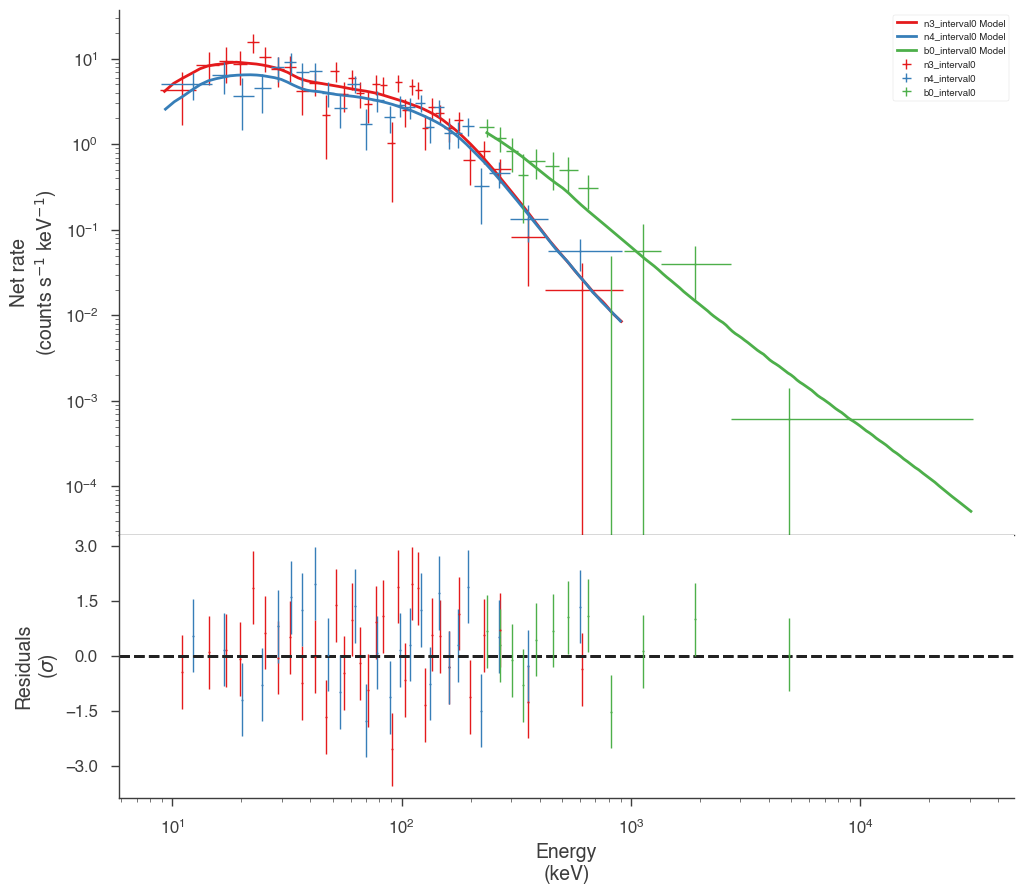

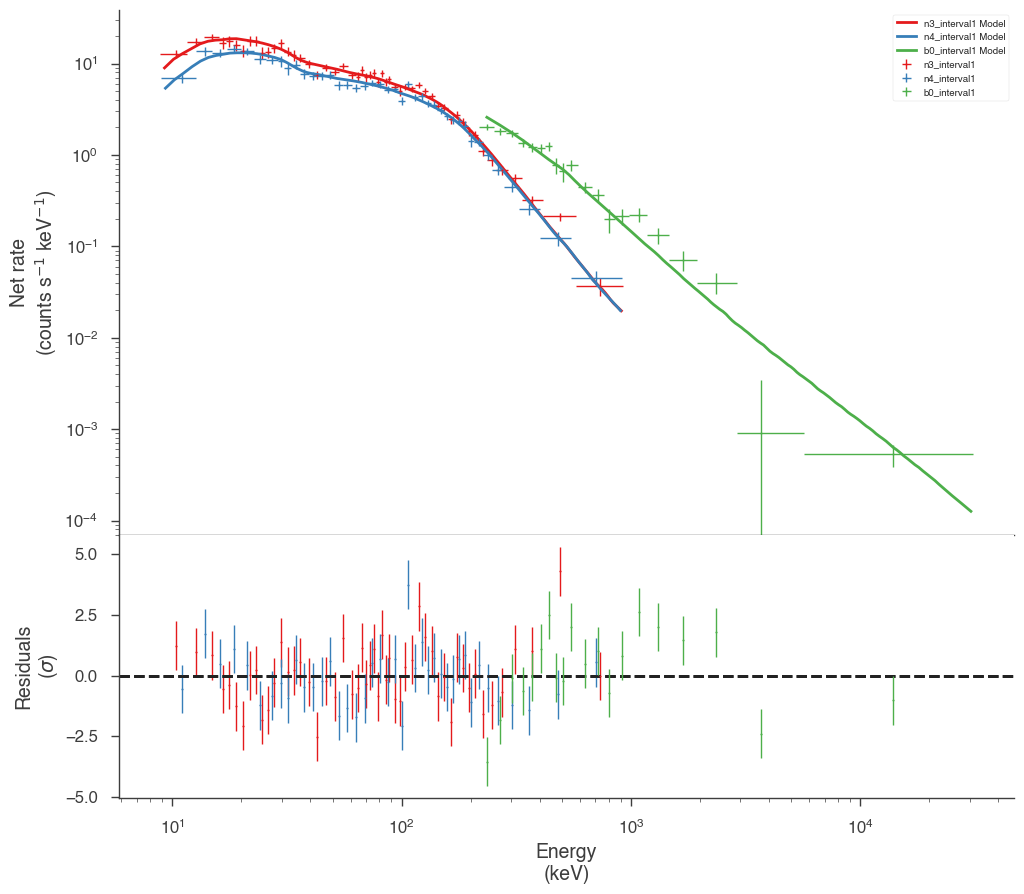

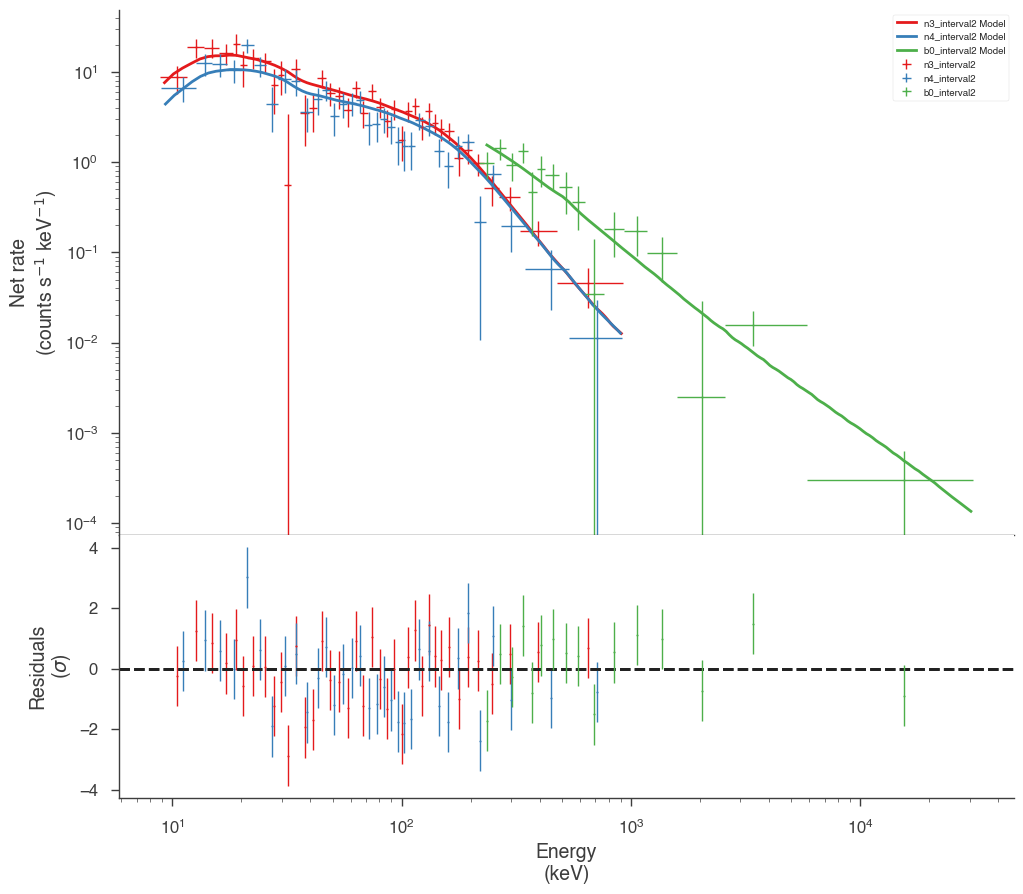

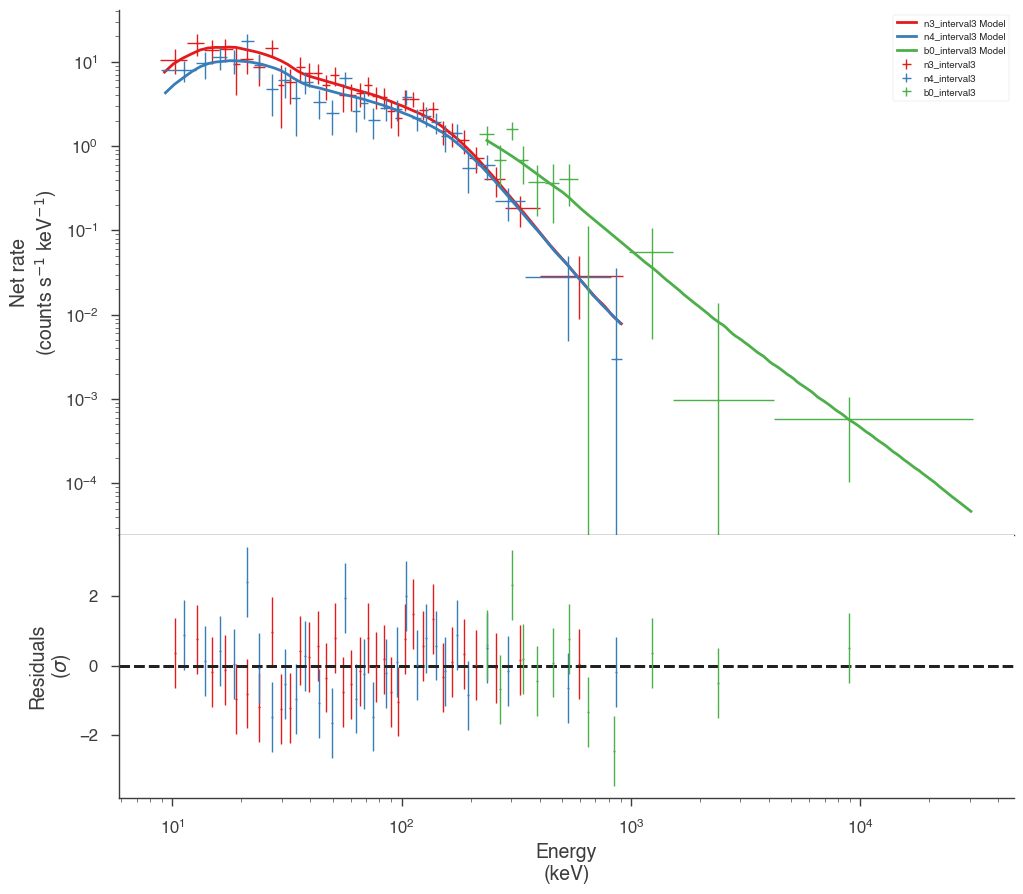

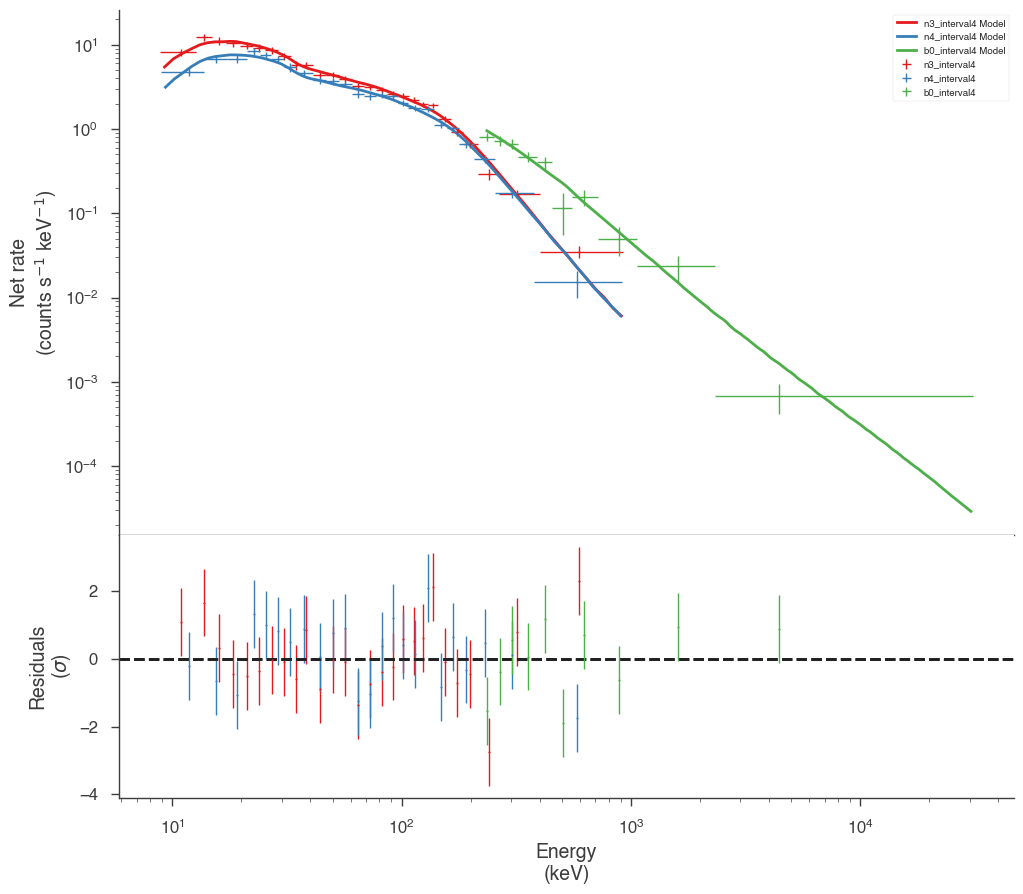

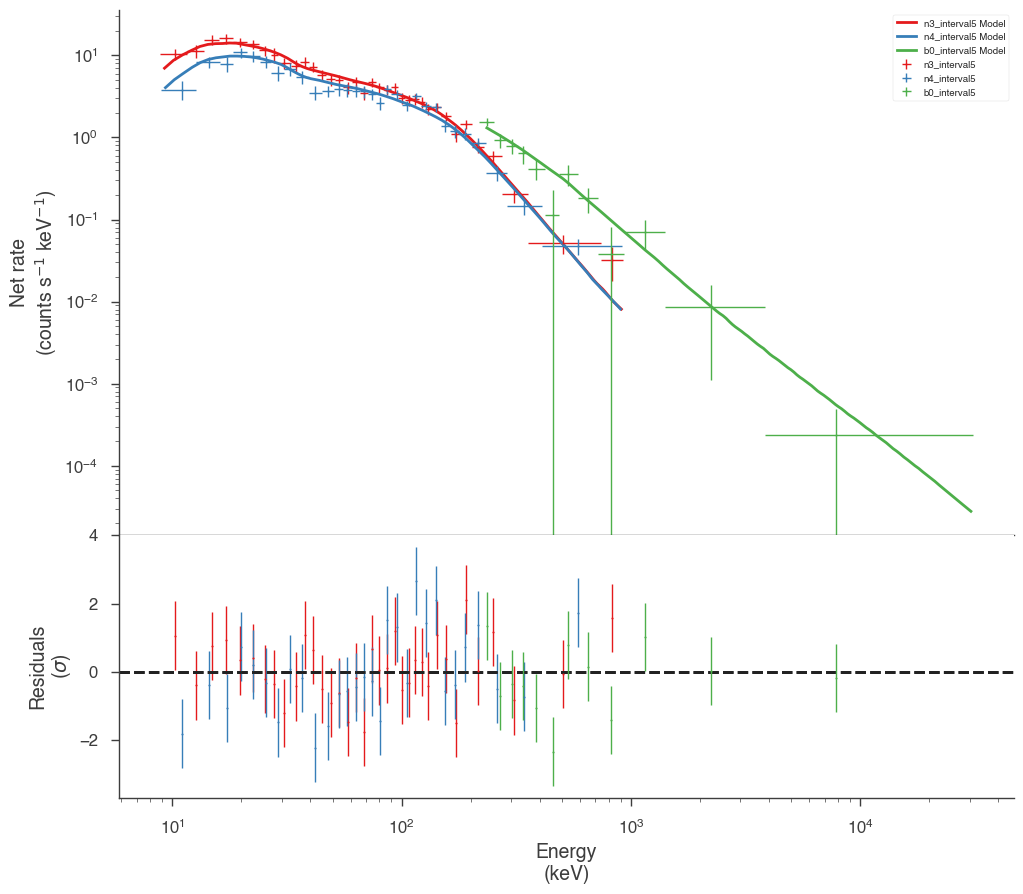

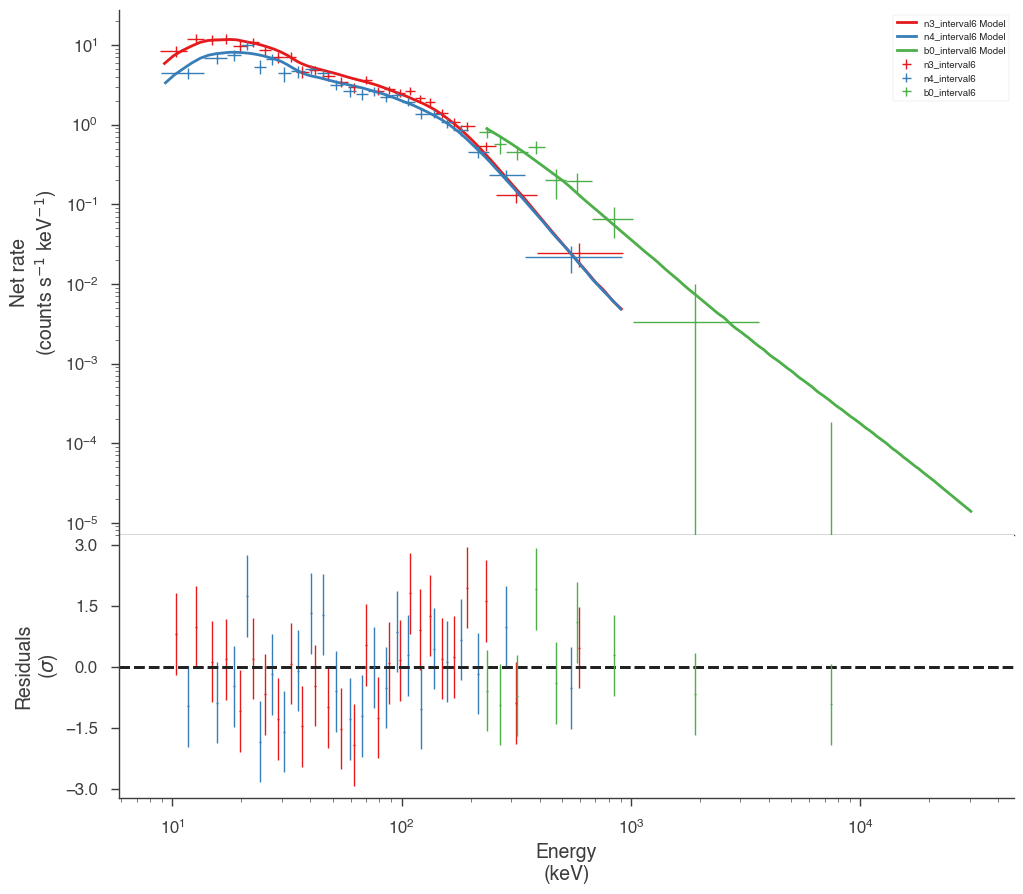

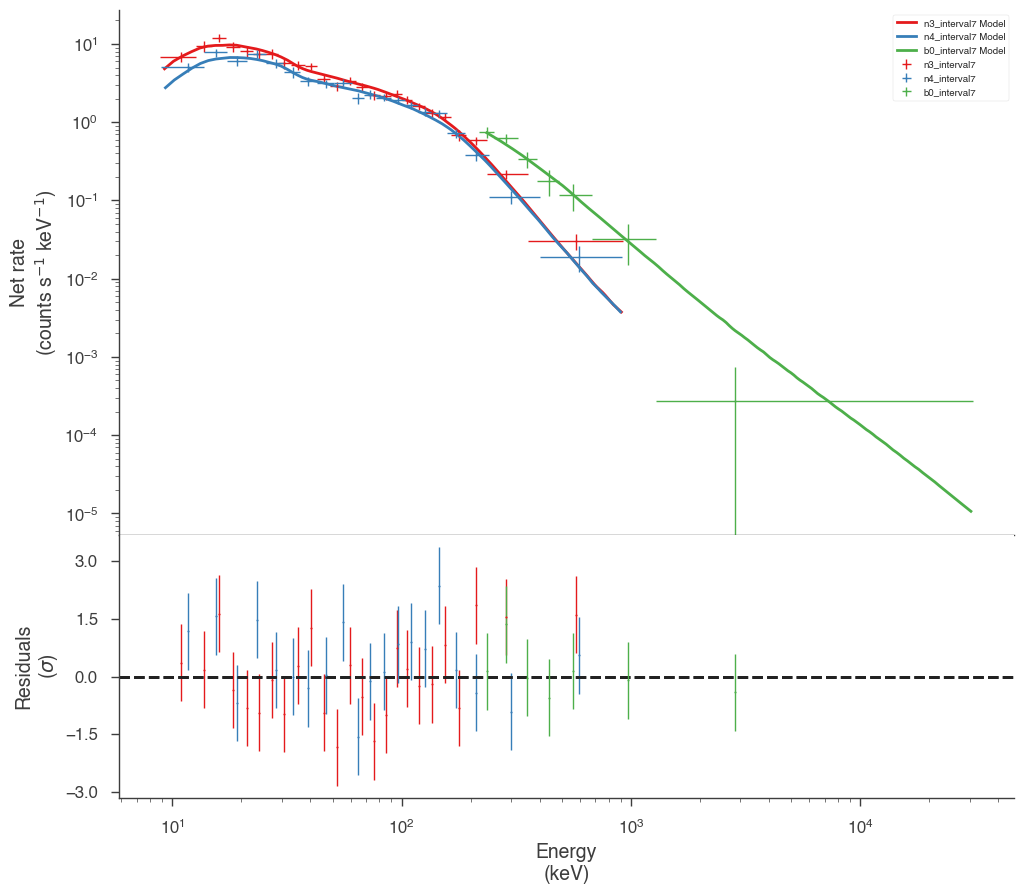

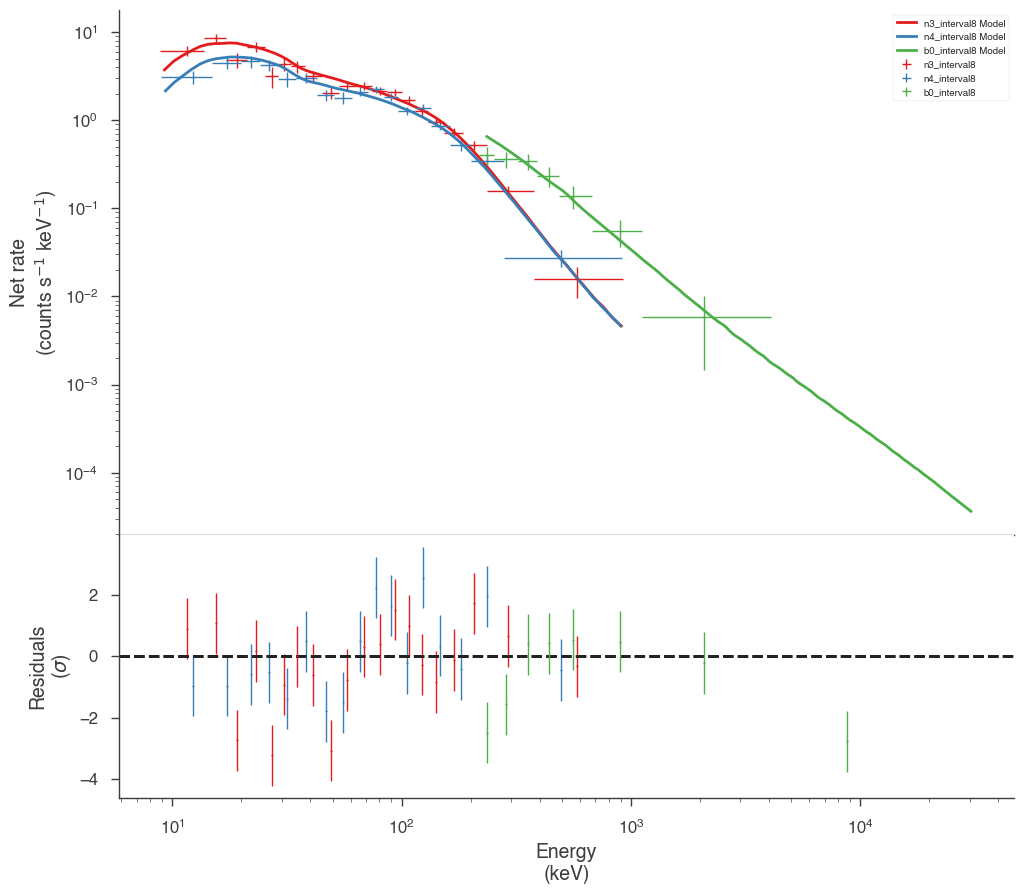

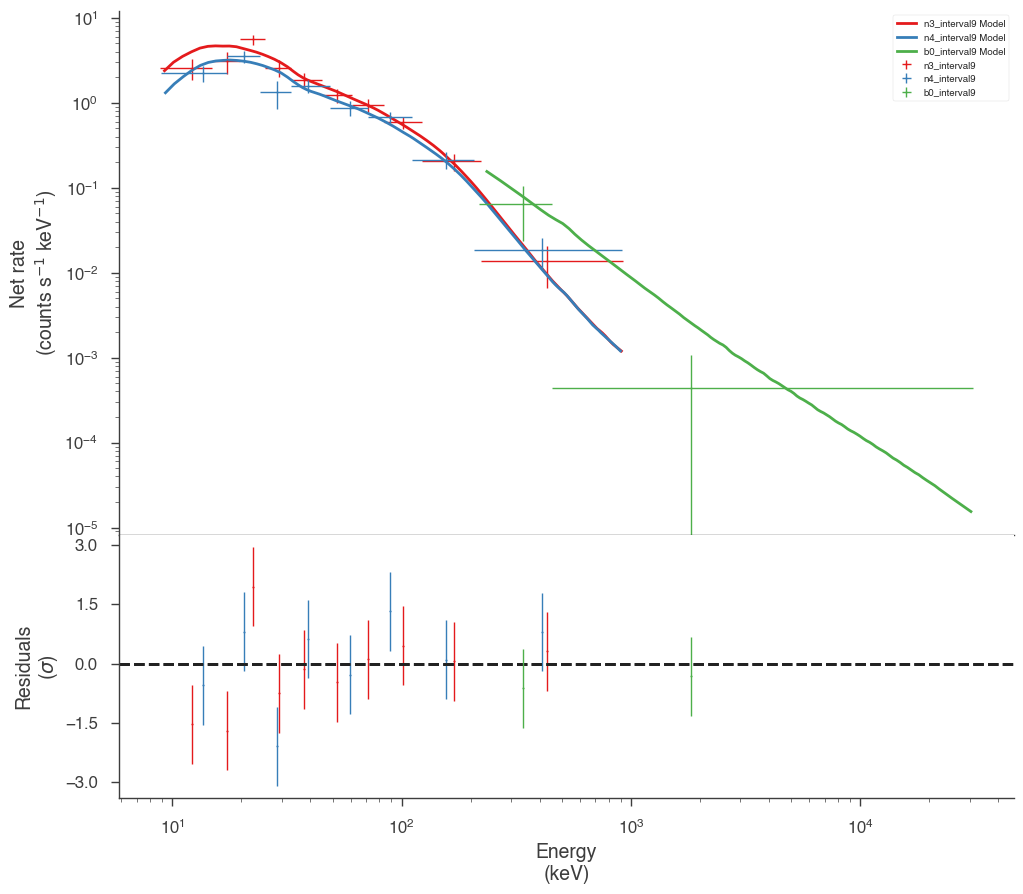

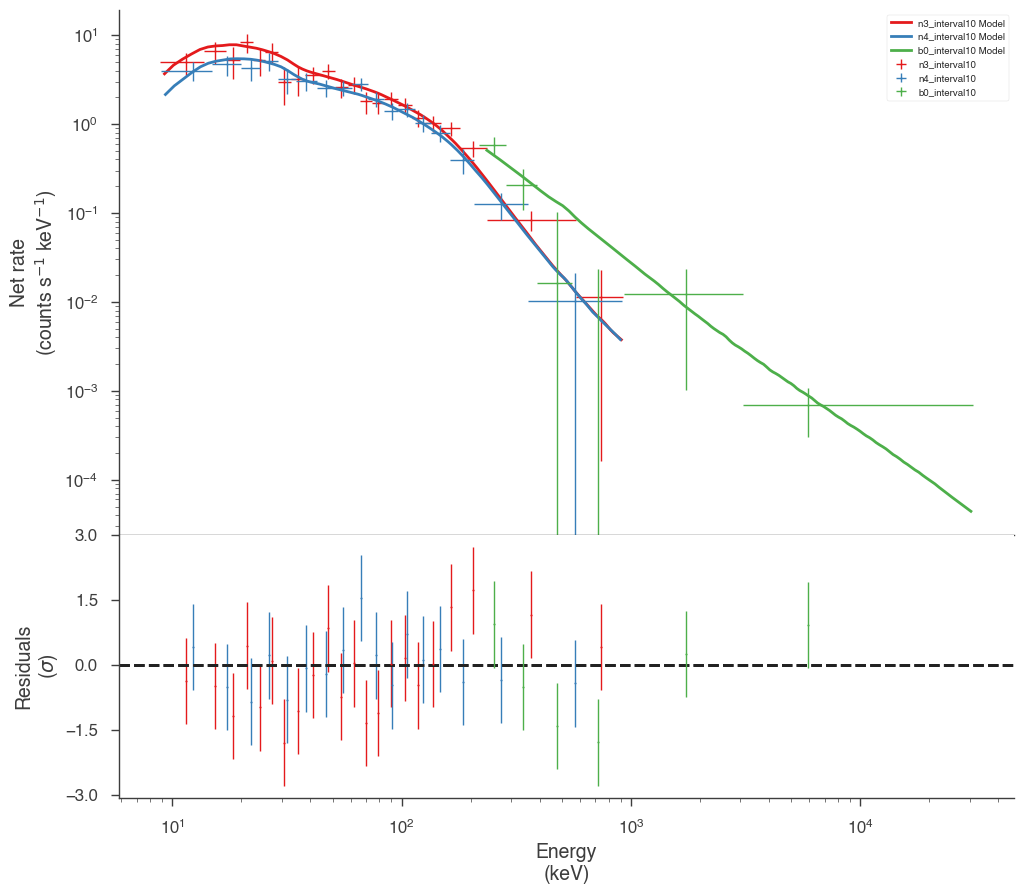

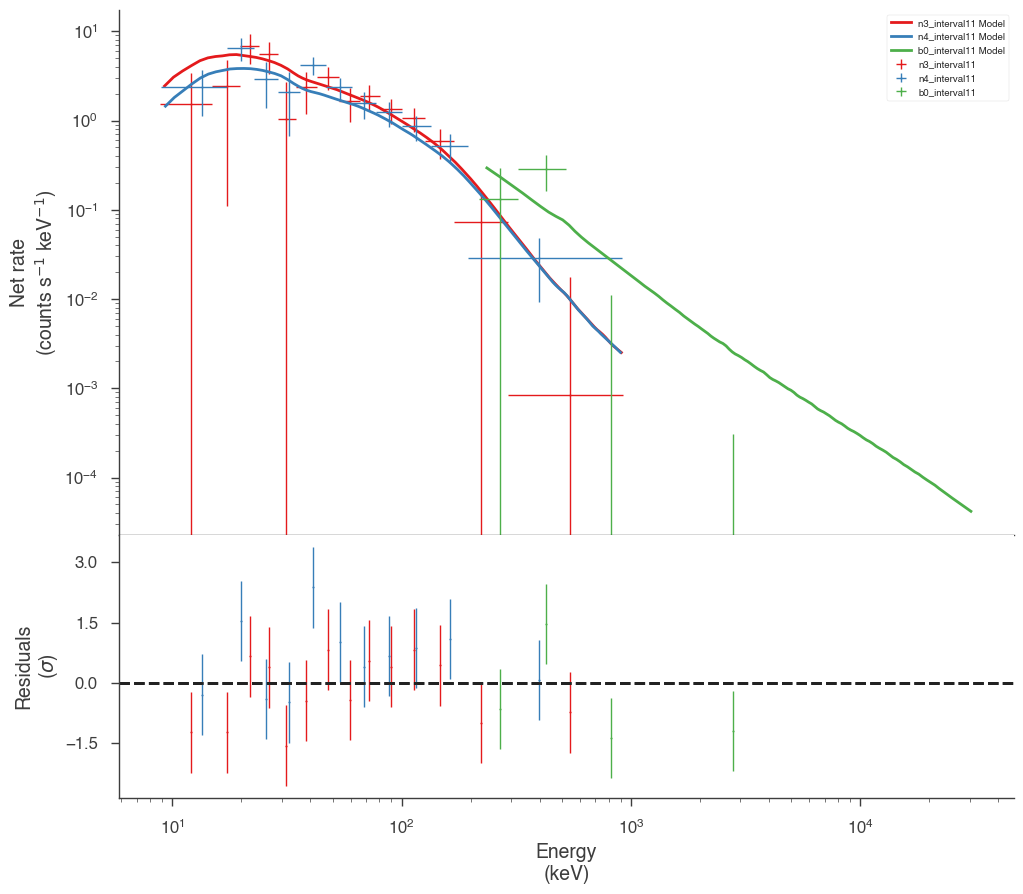

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

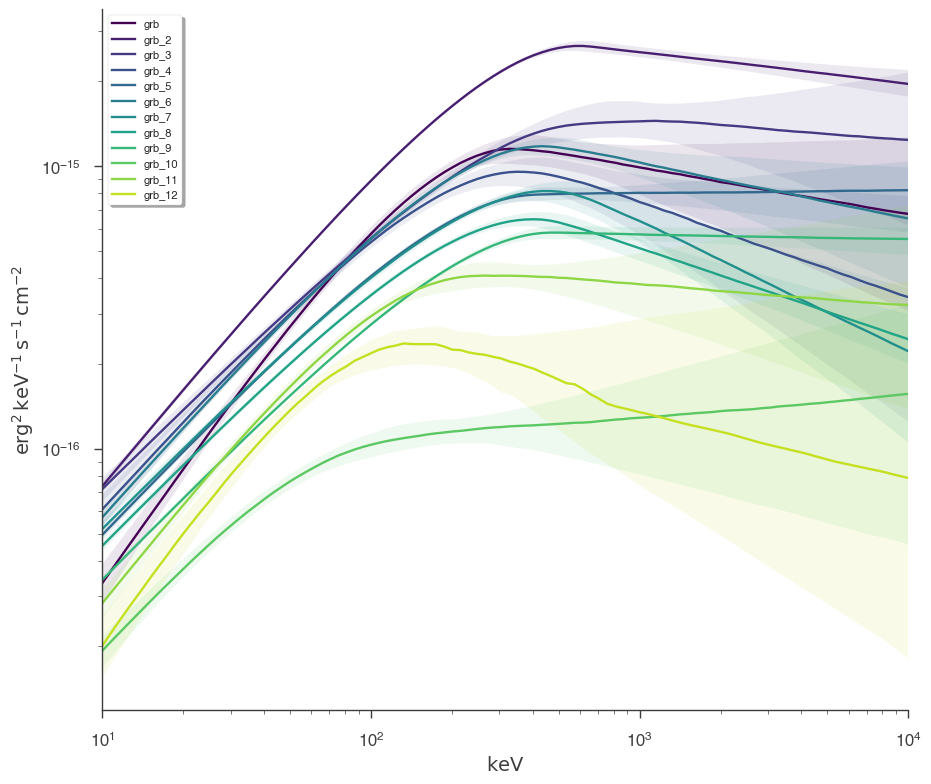

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.